# Using Custom LLM Endpoints

This notebook demonstates how you can use LLMs that are hosted within your own organization/enterprise. In this notebook, we will be using MITRE hosted LLMs to demonstrate this.


In [32]:
%%capture --no-stderr
# install the required dependencies
%pip install -U langchain-openai langgraph langchain_openai

In [33]:
import getpass

MITRE_API_KEY = getpass.getpass(prompt="Enter MITRE LLM Endpoint API Key:")


Enter MITRE LLM Endpoint API Key: ········


In [77]:
from typing import Optional, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
import random

# Input Object
class InputState(TypedDict):
    query: str

# Output Object
class OutputState(InputState):
    dice_roll: int
    user_guess: int
    response: str

# Create a generic client
def create_generic_client(
    base_url: str,
    model: str,
    api_key: str,
    temperature=0.8,
):
    return ChatOpenAI(
        temperature=temperature,
        api_key=api_key,
        base_url=base_url,
        model=model,
        top_p=0.3,
    )

# Custom hosted LLM Endpoints
# Mixtral 22B parameter
MITRE_MIXTRAL_8x22B_URL = "https://mixtral-8x22b.k8s.aip.mitre.org/v1"
MITRE_MIXTRAL_8x22B_MODEL = "mistralai/Mixtral-8x22B-Instruct-v0.1"

# Llama 70B parameter
MITRE_LLAMA_11B_URL = "https://llama32-11b.k8s.aip.mitre.org/v1"
MITRE_LLAMA_11B_MODEL = "meta/llama-3.2-11b-vision-instruct"

# Feel free to choose one of the two LLM endpoints defined above
# Here, we are using the Mixtral endpoint/model
client = create_generic_client(base_url=MITRE_MIXTRAL_8x22B_URL, 
                               model=MITRE_MIXTRAL_8x22B_MODEL, 
                               api_key=MITRE_API_KEY)

async def user_guess(state: InputState) -> OutputState:
    messages = [
        (
            "system",
            "You are a helpful assistant. Extract the users guess for the dice roll and return the guess as a numerical value. Do not provide any explanation, just the number that the user guessed",
        ),
        ("human", state["query"]),
    ]

    guess = client.invoke(messages).content
    return OutputState(user_guess=int(guess))
    
    
async def roll_dice(state: OutputState) -> OutputState:
    return OutputState(dice_roll=random.randint(1, 6))

async def success_message(state: OutputState) -> OutputState:
    return OutputState(response="Congratulations!!!! You hit the Jackpot")

async def passifying_message(state: OutputState) -> OutputState:
    response = client.invoke("In 4 to 5 sentences, tell a positive, uplifting story to cheer someone up when they are down on their luck.")
    return OutputState(response=response.content)
    

async def router(state: OutputState) -> Literal["success", "failure"]:
    return "success" if state["dice_roll"]==state["user_guess"] else "failure"


In [78]:
# Set up the workflow
workflow_builder = StateGraph(input=InputState, output=OutputState)
workflow_builder.add_node("guess", user_guess)
workflow_builder.add_node("roll_the_dice", roll_dice)
workflow_builder.add_node("success", success_message)
workflow_builder.add_node("failure", passifying_message)

workflow_builder.add_edge(START, "guess")
workflow_builder.add_edge("guess", "roll_the_dice")
workflow_builder.add_conditional_edges("roll_the_dice", router)
workflow_builder.add_edge("success", END)
workflow_builder.add_edge("failure", END)

workflow = workflow_builder.compile()


/var/folders/3c/j38b7dwj7svg35_f7s8xvg_h0000gn/T/ipykernel_33365/1867440749.py:2: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  workflow_builder = StateGraph(input=InputState, output=OutputState)


Visulaizing the Workflow...


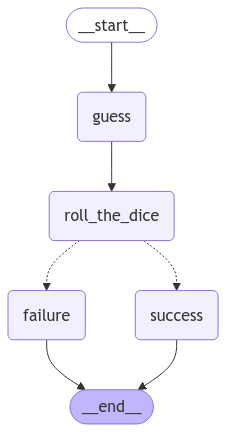

In [81]:
# Visualize the workflow
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

print("Visulaizing the Workflow...")

display(
    Image(
        workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [80]:
# Execute the workflow
response = await workflow.ainvoke(
        InputState(
            query='My guess is a 5',
        )
    )

print(f'User Guessed - {response["user_guess"]}')
print(f'Dice Roll - {response["dice_roll"]}')
print(f'Final Response - {response["response"]}')


User Guessed - 5
Dice Roll - 6
Final Response - Once, a young artist was feeling disheartened because they couldn't sell any of their paintings. One day, they decided to paint a vibrant mural on an old, abandoned wall in their town. The mural depicted a beautiful sunrise, symbolizing hope and new beginnings. As days passed, people began to notice the mural and were deeply moved by its message. Soon, the artist's work gained recognition, and they started receiving commissions for more paintings. This story shows that even when we feel down on our luck, our talents and passions can still bring joy and inspiration to others, ultimately leading to success and happiness.
